In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d
from common.util import create_boundary_mask, create_interior_mask, Dirichlet_bc_tensor, Dirichlet_bc_array
from models.autoencoder import Autoencoder
from loss.loss import unsupervised_loss, h_loss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
f_values = np.arange(-5000, 5000, 2)
np.savetxt('./f_constant.txt', f_values, fmt='%f')
print("Create f_constant.txt.")

Create f_constant.txt.


In [4]:
f_values = np.loadtxt('./f_constant.txt')
print(f"Loaded {len(f_values)} f function.")

Loaded 5000 f function.


In [5]:
input_shape = (256, 256)
f_matrices = np.array([np.full(input_shape, f_value) for f_value in f_values])
print(f"{len(f_matrices)} f matrices")

5000 f matrices


In [6]:
class PoissonDataset(Dataset):
    def __init__(self, f_matrices):
        self.f_matrices = f_matrices

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_matrix = self.f_matrices[idx]
        f_tensor = torch.tensor(f_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return f_tensor

In [7]:
dataset = PoissonDataset(f_matrices)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
a = 0
b = 1
k = 1
M = 255
h = 1 / M

In [9]:
def unsupervised_loss(u_pred, f, h, interior_mask, boundary_mask):
    laplacian_filter = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(u_pred.device) # (1, 1, H, W) 형태로 변환 / 마이너스 라플라시안 필터
    laplacian_u = torch.nn.functional.conv2d(u_pred, laplacian_filter, padding=1)

    interior_loss = torch.sum(((f * h**2 - laplacian_u) ** 2) * interior_mask)
    boundary_loss = torch.sum((u_pred * boundary_mask) ** 2)

    return 0.9*interior_loss + 0.1*boundary_loss

/home/fned/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|          | 1/100 [00:05<08:24,  5.10s/it]

Loss: 70094.3166099597


  2%|▏         | 2/100 [00:08<06:58,  4.27s/it]

Loss: 7884.060660392615


  3%|▎         | 3/100 [00:12<06:26,  3.98s/it]

Loss: 6020.10260981663


  4%|▍         | 4/100 [00:16<06:09,  3.84s/it]

Loss: 4754.802122468402


  5%|▌         | 5/100 [00:19<05:57,  3.76s/it]

Loss: 4285.5596744999


  6%|▌         | 6/100 [00:23<05:49,  3.71s/it]

Loss: 4027.5096777654758


  7%|▋         | 7/100 [00:26<05:44,  3.70s/it]

Loss: 3919.7608209111886


  8%|▊         | 8/100 [00:30<05:38,  3.68s/it]

Loss: 3843.921501402642


  9%|▉         | 9/100 [00:34<05:34,  3.68s/it]

Loss: 3808.6744734648687


 10%|█         | 10/100 [00:37<05:29,  3.66s/it]

Loss: 3778.928939527767


 11%|█         | 11/100 [00:41<05:25,  3.65s/it]

Loss: 3758.428829120223


 12%|█▏        | 12/100 [00:45<05:20,  3.64s/it]

Loss: 3725.4887119949244


 13%|█▎        | 13/100 [00:48<05:16,  3.64s/it]

Loss: 3710.4700830544634


 14%|█▍        | 14/100 [00:52<05:10,  3.62s/it]

Loss: 3697.879412802921


 15%|█▌        | 15/100 [00:55<05:06,  3.60s/it]

Loss: 3684.196921184564


 16%|█▌        | 16/100 [00:59<05:02,  3.60s/it]

Loss: 3675.2297021173367


 17%|█▋        | 17/100 [01:03<04:59,  3.61s/it]

Loss: 3667.516808382265


 18%|█▊        | 18/100 [01:06<04:55,  3.61s/it]

Loss: 3669.3202429121466


 19%|█▉        | 19/100 [01:10<04:51,  3.60s/it]

Loss: 3649.98887760624


 20%|██        | 20/100 [01:14<04:49,  3.62s/it]

Loss: 3642.602269652543


 21%|██        | 21/100 [01:17<04:46,  3.62s/it]

Loss: 3636.2284479809414


 22%|██▏       | 22/100 [01:21<04:43,  3.63s/it]

Loss: 3626.713034465814


 23%|██▎       | 23/100 [01:24<04:40,  3.64s/it]

Loss: 3619.437970009579


 24%|██▍       | 24/100 [01:28<04:38,  3.66s/it]

Loss: 3620.7843468538517


 25%|██▌       | 25/100 [01:32<04:34,  3.65s/it]

Loss: 3616.1975941263186


 26%|██▌       | 26/100 [01:35<04:30,  3.66s/it]

Loss: 3611.804354722333


 27%|██▋       | 27/100 [01:39<04:28,  3.68s/it]

Loss: 3607.773363635798


 28%|██▊       | 28/100 [01:43<04:24,  3.68s/it]

Loss: 3612.829334429115


 29%|██▉       | 29/100 [01:47<04:20,  3.67s/it]

Loss: 3603.840956378135


 30%|███       | 30/100 [01:50<04:16,  3.67s/it]

Loss: 3604.362702776672


 31%|███       | 31/100 [01:54<04:15,  3.70s/it]

Loss: 3600.85933767914


 32%|███▏      | 32/100 [01:58<04:12,  3.71s/it]

Loss: 3596.7038387614452


 33%|███▎      | 33/100 [02:01<04:07,  3.69s/it]

Loss: 3599.5742953355143


 34%|███▍      | 34/100 [02:05<04:05,  3.72s/it]

Loss: 3587.1332183643513


 35%|███▌      | 35/100 [02:09<04:02,  3.74s/it]

Loss: 3611.2086834755673


 36%|███▌      | 36/100 [02:13<03:59,  3.74s/it]

Loss: 3581.9006938569864


 37%|███▋      | 37/100 [02:16<03:55,  3.73s/it]

Loss: 3576.3431676390824


 38%|███▊      | 38/100 [02:20<03:50,  3.72s/it]

Loss: 3584.9974077552747


 39%|███▉      | 39/100 [02:24<03:44,  3.68s/it]

Loss: 3571.3987267366642


 40%|████      | 40/100 [02:27<03:39,  3.65s/it]

Loss: 3570.8456098228503


 41%|████      | 41/100 [02:31<03:34,  3.63s/it]

Loss: 3560.5798032724174


 42%|████▏     | 42/100 [02:34<03:31,  3.64s/it]

Loss: 3560.304762530479


 43%|████▎     | 43/100 [02:38<03:26,  3.62s/it]

Loss: 3557.4841160865344


 44%|████▍     | 44/100 [02:42<03:22,  3.62s/it]

Loss: 3571.041275315983


 45%|████▌     | 45/100 [02:45<03:18,  3.61s/it]

Loss: 3584.291144304215


 46%|████▌     | 46/100 [02:49<03:12,  3.57s/it]

Loss: 3547.64526930888


 47%|████▋     | 47/100 [02:52<03:07,  3.54s/it]

Loss: 3547.2892459942277


 48%|████▊     | 48/100 [02:56<03:03,  3.54s/it]

Loss: 3549.8938174885548


 49%|████▉     | 49/100 [02:59<03:00,  3.53s/it]

Loss: 3545.83727560833


 50%|█████     | 50/100 [03:03<02:56,  3.53s/it]

Loss: 3538.2364949025928


 51%|█████     | 51/100 [03:06<02:52,  3.53s/it]

Loss: 3534.8781590552844


 52%|█████▏    | 52/100 [03:10<02:49,  3.53s/it]

Loss: 3536.6407851686904


 53%|█████▎    | 53/100 [03:13<02:44,  3.51s/it]

Loss: 3532.7787320082357


 54%|█████▍    | 54/100 [03:17<02:41,  3.50s/it]

Loss: 3530.3723859847732


 55%|█████▌    | 55/100 [03:20<02:38,  3.52s/it]

Loss: 3528.738995788963


 56%|█████▌    | 56/100 [03:24<02:34,  3.52s/it]

Loss: 3525.9142996429637


 57%|█████▋    | 57/100 [03:27<02:31,  3.52s/it]

Loss: 3524.404849301478


 58%|█████▊    | 58/100 [03:31<02:28,  3.53s/it]

Loss: 3523.8007839713127


 59%|█████▉    | 59/100 [03:34<02:24,  3.52s/it]

Loss: 3520.0350252382314


 60%|██████    | 60/100 [03:38<02:20,  3.52s/it]

Loss: 3518.296829515202


 61%|██████    | 61/100 [03:42<02:18,  3.54s/it]

Loss: 3515.7180319622066


 62%|██████▏   | 62/100 [03:45<02:14,  3.53s/it]

Loss: 3513.702275950438


 63%|██████▎   | 63/100 [03:49<02:11,  3.54s/it]

Loss: 3513.155210458549


 64%|██████▍   | 64/100 [03:52<02:07,  3.53s/it]

Loss: 3509.8038065722035


 65%|██████▌   | 65/100 [03:56<02:02,  3.51s/it]

Loss: 3508.1296064048815


 66%|██████▌   | 66/100 [03:59<01:59,  3.50s/it]

Loss: 3507.810563202876


 67%|██████▋   | 67/100 [04:03<01:55,  3.51s/it]

Loss: 3504.253416024955


 68%|██████▊   | 68/100 [04:06<01:52,  3.51s/it]

Loss: 3504.746336335589


 69%|██████▉   | 69/100 [04:10<01:48,  3.50s/it]

Loss: 3500.7258642889133


 70%|███████   | 70/100 [04:13<01:45,  3.52s/it]

Loss: 3500.4696414242885


 71%|███████   | 71/100 [04:17<01:41,  3.51s/it]

Loss: 3497.5267707192975


 72%|███████▏  | 72/100 [04:20<01:38,  3.51s/it]

Loss: 3498.5922618307127


 73%|███████▎  | 73/100 [04:24<01:35,  3.52s/it]

Loss: 3497.4742785411277


 74%|███████▍  | 74/100 [04:27<01:31,  3.52s/it]

Loss: 3494.236031501916


 75%|███████▌  | 75/100 [04:31<01:27,  3.51s/it]

Loss: 3497.431523608554


 76%|███████▌  | 76/100 [04:34<01:24,  3.52s/it]

Loss: 3493.302167564441


 77%|███████▋  | 77/100 [04:38<01:21,  3.54s/it]

Loss: 3492.841718345691


 78%|███████▊  | 78/100 [04:41<01:17,  3.54s/it]

Loss: 3489.3377397865247


 79%|███████▉  | 79/100 [04:45<01:14,  3.54s/it]

Loss: 3490.177718824642


 80%|████████  | 80/100 [04:48<01:10,  3.53s/it]

Loss: 3489.3023040188345


 81%|████████  | 81/100 [04:52<01:07,  3.54s/it]

Loss: 3489.007739413316


 82%|████████▏ | 82/100 [04:56<01:03,  3.54s/it]

Loss: 3485.9630896695858


 83%|████████▎ | 83/100 [04:59<01:00,  3.55s/it]

Loss: 3486.5993695107236


 84%|████████▍ | 84/100 [05:03<00:56,  3.56s/it]

Loss: 3488.968430051378


 85%|████████▌ | 85/100 [05:06<00:53,  3.55s/it]

Loss: 3485.3390079182423


 86%|████████▌ | 86/100 [05:10<00:49,  3.53s/it]

Loss: 3485.338703519979


 87%|████████▋ | 87/100 [05:13<00:46,  3.54s/it]

Loss: 3483.1300394823597


 88%|████████▊ | 88/100 [05:17<00:42,  3.54s/it]

Loss: 3482.2903597886393


 89%|████████▉ | 89/100 [05:20<00:38,  3.53s/it]

Loss: 3491.303785190461


 90%|█████████ | 90/100 [05:24<00:35,  3.54s/it]

Loss: 3481.3056158563895


 91%|█████████ | 91/100 [05:27<00:31,  3.53s/it]

Loss: 3481.2413229000795


 92%|█████████▏| 92/100 [05:31<00:28,  3.52s/it]

Loss: 3481.4530029296875


 93%|█████████▎| 93/100 [05:34<00:24,  3.52s/it]

Loss: 3482.402100775652


 94%|█████████▍| 94/100 [05:38<00:21,  3.53s/it]

Loss: 3480.2894559240644


 95%|█████████▌| 95/100 [05:41<00:17,  3.50s/it]

Loss: 3481.8984880386643


 96%|█████████▌| 96/100 [05:45<00:13,  3.50s/it]

Loss: 3478.2487862945363


 97%|█████████▋| 97/100 [05:48<00:10,  3.50s/it]

Loss: 3479.3778694298617


 98%|█████████▊| 98/100 [05:52<00:06,  3.49s/it]

Loss: 3477.8156816033043


 99%|█████████▉| 99/100 [05:55<00:03,  3.49s/it]

Loss: 3479.4075919959196


100%|██████████| 100/100 [05:59<00:00,  3.59s/it]

Loss: 3478.882479722333


Last Loss: 3478.8825 Last model saved to last_autoencoder_model.pth
Best Loss: 3477.8157 Best model saved to best_autoencoder_model.pth


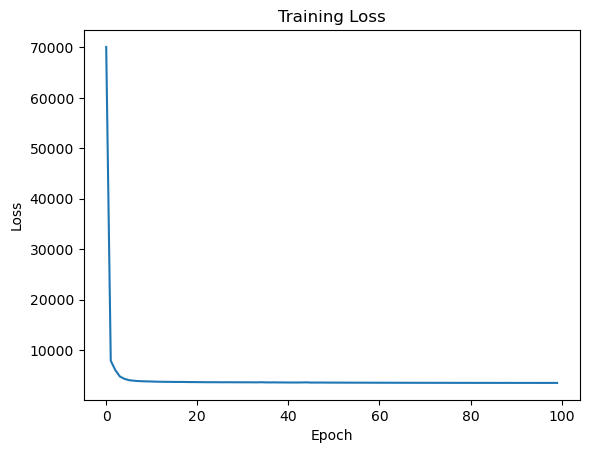

In [10]:
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

boundary_mask = create_boundary_mask((256, 256)).to(device)
interior_mask = create_interior_mask((256, 256)).to(device)

num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        u_pred, _ = model(inputs)
        u_pred = Dirichlet_bc_tensor(u_pred, g=0)
        loss = unsupervised_loss(u_pred, inputs, h, interior_mask, boundary_mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = model.state_dict()

torch.save(model.state_dict(), 'last_autoencoder_model.pth')
torch.save(best_model_wts, 'best_autoencoder_model.pth')

print(f'Last Loss: {train_loss:.4f} Last model saved to last_autoencoder_model.pth')
print(f'Best Loss: {best_loss:.4f} Best model saved to best_autoencoder_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [11]:
model.load_state_dict(torch.load('best_autoencoder_model.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
    (11): ReLU()
  )
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=131072, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 32, 32))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2)

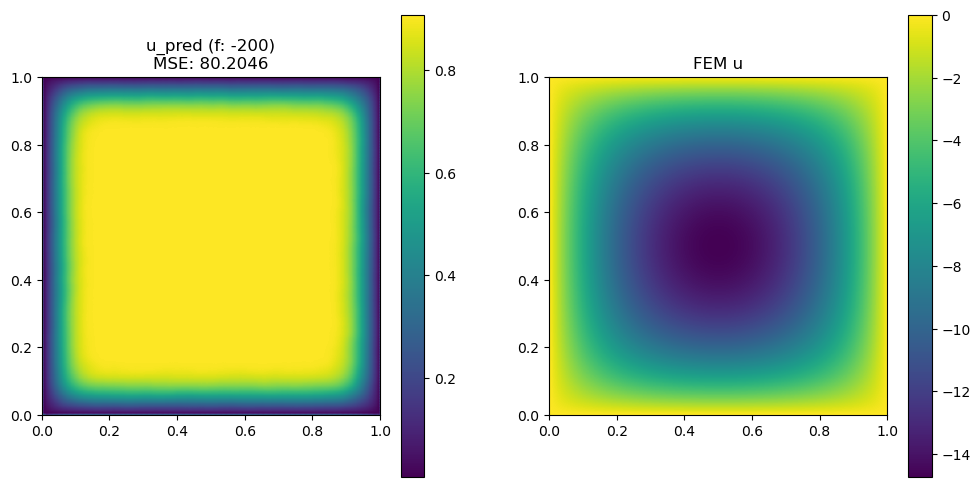

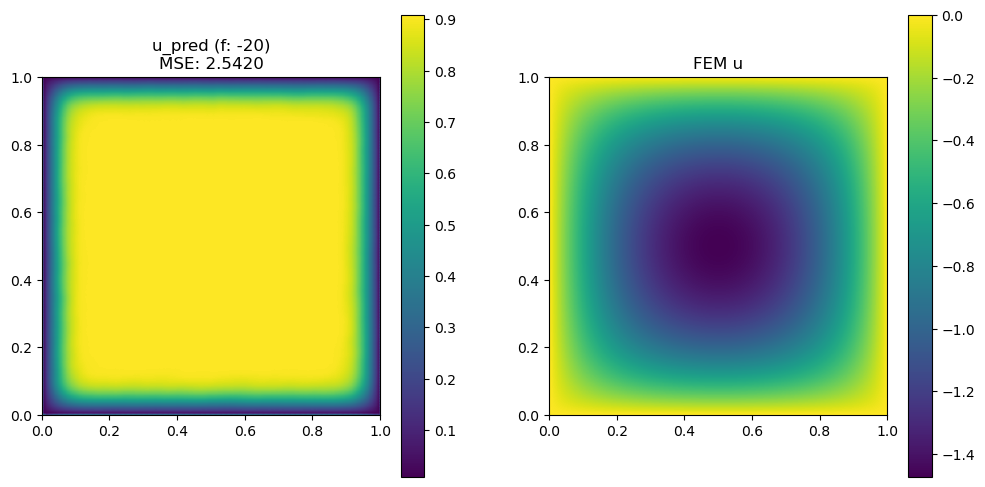

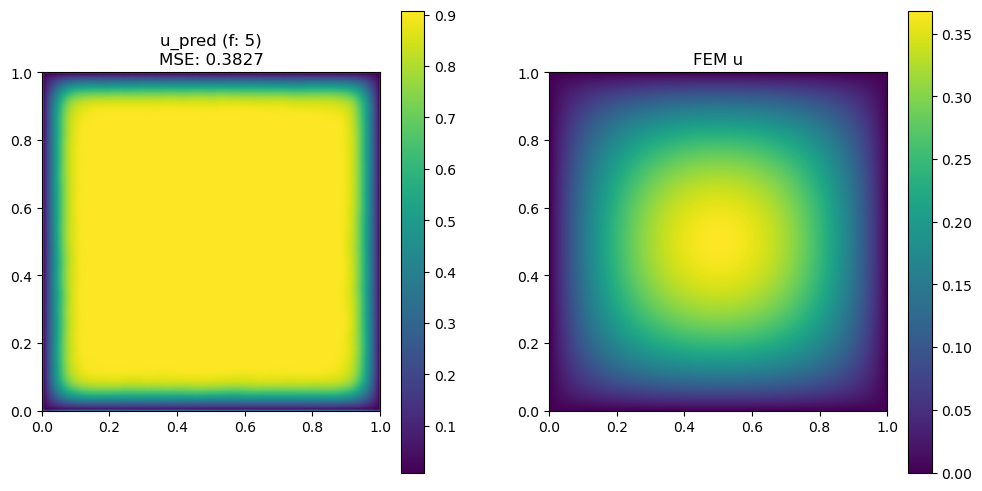

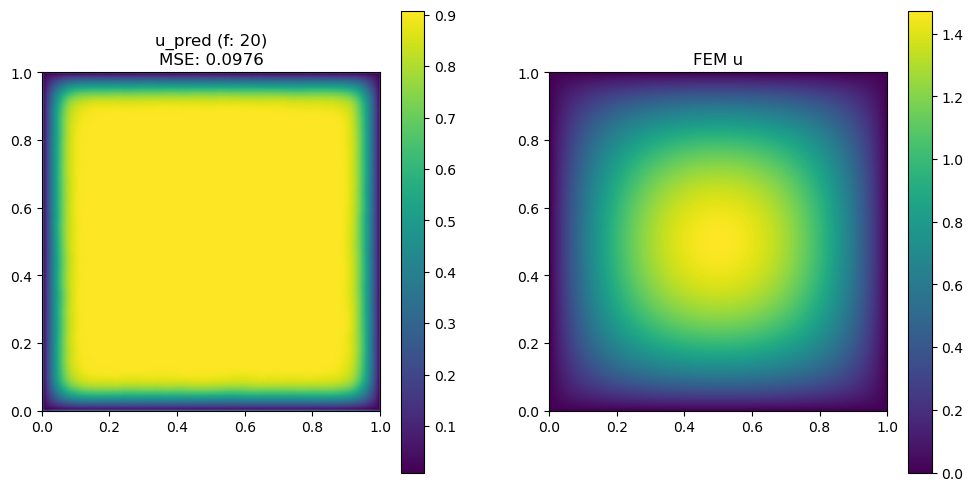

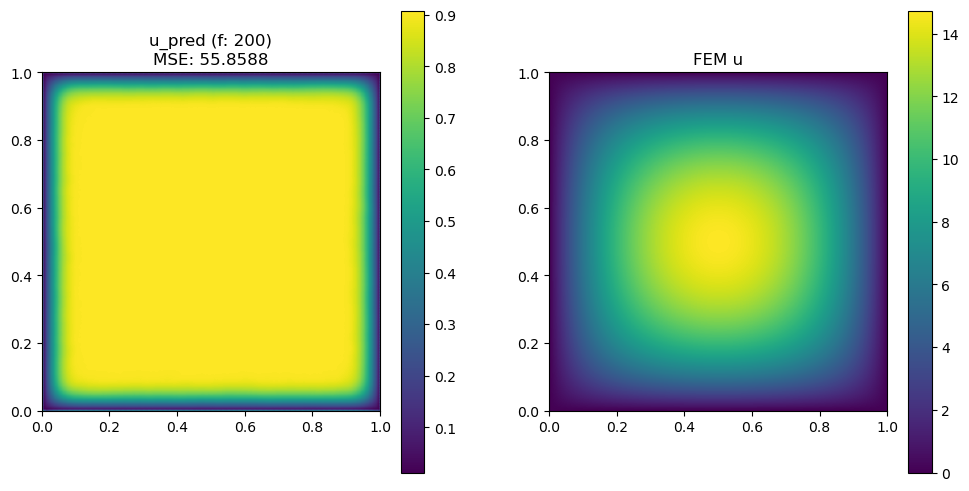

In [12]:
test_f_values = [-200, -20, 5, 20, 200]
c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

for test_f_value in test_f_values:
    new_f = np.full((256, 256), test_f_value)
    f_tensor = torch.tensor(new_f).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        predicted_u, _ = model(f_tensor)

    predicted_u = predicted_u.squeeze().cpu().numpy()

    f = lambda x: np.full(x.shape[0], test_f_value)
    u_D = lambda x: x[:,0] * 0

    fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
    fem_u_reshaped = fem_u.reshape((256, 256))
    
    mse = np.mean((predicted_u - fem_u_reshaped) ** 2)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"u_pred (f: {test_f_value})\nMSE: {mse:.4f}")
    plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"FEM u")
    plt.imshow(fem_u_reshaped, cmap='viridis', extent=(0, 1, 0, 1))
    plt.colorbar()

    plt.show()

In [13]:
test_f_values = [-200, -20, 5, 20, 200]
c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

for test_f_value in test_f_values:
    new_f = np.full((256, 256), test_f_value)
    f_tensor = torch.tensor(new_f).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        predicted_u, _ = model(f_tensor)

    predicted_u = predicted_u.squeeze().cpu().numpy()

    f = lambda x: np.full(x.shape[0], test_f_value)
    u_D = lambda x: x[:,0] * 0

    fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
    fem_u_reshaped = fem_u.reshape((256, 256))
    
    mse = np.mean((predicted_u - fem_u_reshaped) ** 2)
    print(f'Mean Squared Error: {mse}\n')
    print(f'Predicted u: \n{predicted_u}\n')
    print(f'FEM u: \n{fem_u_reshaped}\n')

Mean Squared Error: 80.20459755990997

Predicted u: 
[[0.5294039  0.08844393 0.10802761 ... 0.14237751 0.08595798 0.48110944]
 [0.28808662 0.00584673 0.00979527 ... 0.00904361 0.00567205 0.24761662]
 [0.22190653 0.00862902 0.01520924 ... 0.01554736 0.00880256 0.17471094]
 ...
 [0.30156428 0.00970267 0.01655117 ... 0.01593307 0.00982716 0.2395245 ]
 [0.24543723 0.00619114 0.01055425 ... 0.00892946 0.00667176 0.15998705]
 [0.67972416 0.19932836 0.20688176 ... 0.17866765 0.11443649 0.3726047 ]]

FEM u: 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0104596  -0.01917227 ... -0.01917227 -0.0104596
   0.        ]
 [ 0.         -0.01917227 -0.03610501 ... -0.03610501 -0.01917227
   0.        ]
 ...
 [ 0.         -0.01917227 -0.03610501 ... -0.03610501 -0.01917227
   0.        ]
 [ 0.         -0.0104596  -0.01917227 ... -0.01917227 -0.0104596
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]

Mean Squared Error: